In [1]:
from naima.models import ExponentialCutoffPowerLaw, InverseCompton
import astropy.units as u
import numpy as np


def model_function(pars, data):
    amplitude = pars[0] * (1 / u.eV)
    alpha = pars[1]
    e_cutoff = (10 ** pars[2]) * u.TeV
    e_0 = 10 * u.TeV

    ECPL = ExponentialCutoffPowerLaw(amplitude, e_0, alpha, e_cutoff)
    IC = InverseCompton(
        ECPL,
        seed_photon_fields=[
            "CMB",
            ["FIR", 26.5 * u.K, 0.415 * u.eV / u.cm ** 3],
        ],
    )

    # The total enegy in electrons of model IC can be accessed through the
    # attribute We or obtained for a given range with compute_We
    We = IC.compute_We(Eemin=1 * u.TeV)

    # We can also save the particle distribution between 100 MeV and 100 TeV
    electron_e = np.logspace(11, 15, 100) * u.eV
    electron_dist = ECPL(electron_e)

    # The first object returned must be the model photon spectrum, and
    # subsequent objects will be stored as metadata blobs
    return IC(data), (electron_e, electron_dist), We

## Tutorial

The first step in fitting a model to an observed spectrum is to read the spectrum into the appropriate format. See Data format for an explanation of the format and an example, and Units system for a brief explanation of the unit system used in Naima. We load the spectral data with astropy.io.ascii:

In [2]:
from astropy.io import ascii

data = ascii.read("RXJ1713_HESS_2007.dat")
data

energy,energy_edge_lo,energy_edge_hi,flux,flux_error,ul
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),
float64,float64,float64,float64,float64,int64
0.33,0.3,0.37,2.29e-10,3.2e-11,0
0.4,0.37,0.44,1.25e-10,1.6e-11,0
0.49,0.44,0.54,9.46e-11,9e-12,0
0.59,0.54,0.65,6.06e-11,5.2e-12,0
0.71,0.65,0.79,4.37e-11,3.1e-12,0
0.86,0.79,0.95,2.15e-11,1.8e-12,0
...,...,...,...,...,...
22.18,20.24,24.5,9.24e-15,3.16e-15,0


In [3]:
from naima.models import ExponentialCutoffPowerLaw, InverseCompton
import astropy.units as u


def model(pars, data):
    amplitude = pars[0] / u.eV
    alpha = pars[1]
    e_cutoff = (10 ** pars[2]) * u.TeV

    ECPL = ExponentialCutoffPowerLaw(amplitude, 10 * u.TeV, alpha, e_cutoff)
    IC = InverseCompton(
        ECPL,
        seed_photon_fields=[
            "CMB",
            ["FIR", 26.5 * u.K, 0.415 * u.eV / u.cm ** 3],
        ],
    )

    return IC.flux(data, distance=1.0 * u.kpc)

In [4]:
import naima

In [5]:
from naima import uniform_prior

def lnprior(pars):
    lnprior = uniform_prior(pars[0], 0.0, np.inf) + uniform_prior(pars[1], -1, 5)
    return lnprior

In [6]:
import numpy as np
p0 = np.array((1e33, 3.0, np.log10(30)))
labels = ["norm", "index", "log10(cutoff)"]

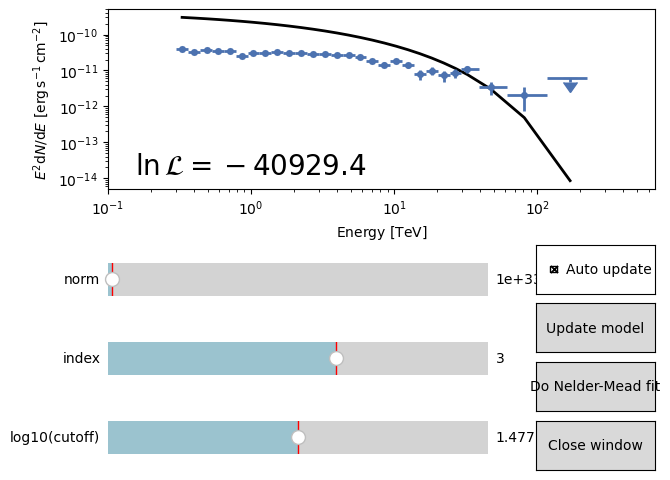

In [7]:
imf = naima.InteractiveModelFitter(model, p0, data=data, labels=labels)
# interactive fitting done
p0 = imf.pars

In [11]:
naima.get_sampler(data)

TypeError: Model function is missing!

INFO: Launching interactive model fitter, close when finished [naima.core]


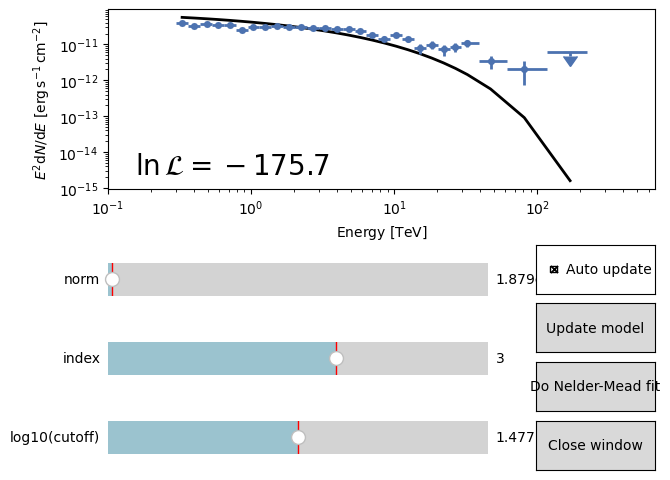

Burning in the 128 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :    1.87e+32          2.94            1.48      
  Last ensemble std    :    1.63e+31          0.317           0.142     
  Last ensemble lnprob :  avg: -241.508, max: -24.064

Progress of the run: 10 percent (5 of 50 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :    1.84e+32          2.83            1.47      
  Last ensemble std    :    2.02e+31          0.321           0.159     
  Last ensemble lnprob :  avg: -137.826, max: -19.535

Progress of the run: 20 percent (10 of 50 steps)
                           -----norm------ -----index----- -log10(cutoff)-
  Last ensemble median :    1.81e+32          2.65            1.48      
  Last ensemble std    :    2.19e+31          0.28            0.164     
  Last ensemble lnprob :  avg: -85.578

In [9]:
import naima

sampler, pos = naima.run_sampler(
    data_table=data,
    p0=p0,
    labels=labels,
    model=model,
    prior=lnprior,
    nwalkers=128,
    nburn=50,
    nrun=10,
    threads=4,
     interactive=True,
)

In [10]:


naima.save_diagnostic_plots(
    "RXJ1713_IC",
    sampler,
    blob_labels=[
        "Spectrum",
        "Electron energy distribution",
        "$W_e (E_e>1$ TeV)",
    ],
)

naima.save_results_table("RXJ1713_naima_fit", sampler)



INFO: Plotting chain of parameter norm... [naima.analysis]
INFO: -----------------------norm-----------------------
          norm = $(1.43^{+0.16}_{-0.10})\times10^{32}$ [naima.plot]
INFO: Plotting chain of parameter index... [naima.analysis]
INFO: ----------------------index-----------------------
          index = $2.53 \pm 0.13$ [naima.plot]
INFO: Plotting chain of parameter log10(cutoff)... [naima.analysis]
INFO: ------------------log10(cutoff)-------------------
          log10(cutoff) = $1.63 \pm 0.12$
                 cutoff = $43^{+15}_{-10}$ [naima.plot]
INFO: Plotting corner plot... [naima.analysis]
INFO: Plotting Spectrum... [naima.analysis]
INFO: Plotting Electron energy distribution... [naima.analysis]
INFO: Saving results table in RXJ1713_naima_fit_results.ecsv [naima.analysis]


/home/born-again/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


label,median,unc_lo,unc_hi
bytes72,float64,float64,float64
norm,1.4315727676032511e+32,1.045165608728871e+31,1.6189140617117604e+31
index,2.5328867294318798,0.13820587121286598,0.1122153903654679
log10(cutoff),1.6298087751223842,0.11791846363857794,0.1307870848683821
cutoff,42.639175581578144,10.138655443222014,14.983938286962385
blob1,nan,nan,nan
